# 流体の基礎方程式

## はじめに

数値流体力学(CFD)の勉強も兼ねて、気液二相の数値流体解析コードの構築に必要な知識などをまとめていきたいと思います。間違い等多々含まれていると思われますので、発見された際にはご連絡していただいけると幸いです。


### 対象読者

* Pythonを使える人
* 数値計算に興味がある人
* 流体力学に興味がある人
* 基本的な大学物理や数学を理解している人(簡単な微分方程式と線形代数くらい？)


### シリーズ


* 1章：[【Python】流体シミュレーション：移流方程式を実装する](https://qiita.com/KQTS/items/354c85adb7d46e28e8da)
* 2章：[【Python】流体シミュレーション : 拡散方程式を実装する](https://qiita.com/KQTS/items/97daa509991bb9777a4a)
    * 2章の補足的な立ち位置：[【Python】疎行列計算が高速にできるようになる記事](https://qiita.com/KQTS/items/e5500ba6e2681456e268)
* 3章：[【Python】流体シミュレーション : 線形から非線形へ](https://qiita.com/KQTS/items/0c4f6c47a4d56881a178)
* この記事

### 本記事の大まかな内容

本記事では、気体のみが系に存在する場合の数値シミュレーションを考えます。流体の支配方程式について簡単に説明した後、液体のシミュレーションで対象となる非圧縮性流体の数値計算を実装する構成となっております。

## 目次
|章|タイトル|備考|
|:---|:---|:---|
|1.  |[流体解法](#1-流体解法)||
|1.1.|[流体の支配方程式](#1-1-流体の支配方程式)||
|1.2.|[圧縮性と非圧縮性](#1-2-圧縮性と非圧縮性)||
|2.  |[非圧縮性流体の計算アルゴリズム](#2-非圧縮性流体の計算アルゴリズム)||
|2.1.|[空間差分](#2-1-空間差分)||
|2.2.|[MAC法](#2-2-MAC法)|Marker And Cell method|
|2.3.|[Fractional Step法](#2-3-fractional-step法)|部分段階法とも言う|
|2.4.|[SIMPLE法](#2-4-simple法)|Semi-Implicit Method for Pressure-Linked Equation method|
|2.5.|[CCUP法](#2-5-ccup法)|CIP-Combined Unified Procedure method|
|3.|[実装](#3-実装)|CCUP法(有限差分法)|


## 1. 流体解法
### 1-1. 流体の支配方程式

流体は、連続の式・Navier Stokes方程式・エネルギー方程式の３つの方程式により表されます。それぞれの方程式は、質量保存・運動量保存・エネルギー保存から導出されます。以下に非保存系で流体の支配方程式をそれぞれ記し、右辺を0にすれば密度・速度・内部エネルギーの移流方程式を意味します。この非保存系とは微分の外に変数が存在する形のことで、計算結果が保存則を満たしている保証がないため、数値計算の際には保存性の確認を行う必要があります。非保存系の逆は保存系です。

* **連続の式**

$$
\frac{\partial \rho}{\partial t} +  (\vec{u} \cdot \nabla) \rho  =   - \rho \nabla \cdot \vec{u}  \\
\quad or \\
\frac{\partial \rho}{\partial t} + \nabla \rho \vec{u} = 0
$$

ある検査体積内の質量変化が、表面から流出入する質量流量$\rho \vec{u}$を面積分したものに等しいことから導けます。わかりやすい例で説明すると、財布の中のお金の変化量は、財布の出入り口を通過した金額を差し引きしたものと等しいことを上式は表しております。

* **Navier Stokes 方程式(流体の運動方程式)**

$$
\rho \frac{\partial \vec{u}}{\partial t} + \rho (\vec{u} \cdot \nabla)\vec{u} = - \nabla p + \mu \nabla^2 \vec{u} + (\mu + \lambda) \nabla (\nabla \cdot \vec{u}) + \vec{F_B} \\
 \quad or \\
\rho \frac{\partial \vec{u}}{\partial t} + \rho (\vec{u} \cdot \nabla)\vec{u} = - \nabla p + \nabla \cdot {\bf T}_{\nu} + \vec{F_B} \\
, where \quad {\bf T}_{\nu} = \lambda (\nabla \cdot \vec{u}) {\bf I} + 2 \mu {\bf D} \quad : 粘性応力テンソル \\
{\bf D}  = \frac{1}{2} \left\{(\nabla \vec{u}) + (\nabla \vec{u})^T \right\} : ひずみ速度テンソル \\
\quad \vec{F_B} \quad : 体積力(主に重力) \\
\quad \mu : 粘性係数
$$

流体の移動によって運動量が、圧力勾配$\nabla p$、粘性による拡散$ \nabla \cdot {\bf T}_{\nu}$、体積力(重力等)$\vec{F_B}$の影響を受けることを表しています。


* **エネルギー方程式**

$$
 \rho \frac{\partial e}{\partial t} + \rho (\vec{u} \cdot \nabla) e = -p \nabla \cdot \vec{u} - \nabla \cdot (\kappa \nabla T) + {\bf T}_{\nu} : {\bf D} + \dot{L} \\
, where \quad  \dot{L} : 化学反応などによる熱の発生量 \\
\quad \kappa : 熱伝導率
$$

流体の内部エネルギー変化量は、圧力による仕事$\nabla \cdot \vec{u}$、熱伝導によるエネルギー収支$\nabla \cdot (\kappa \nabla T)$、粘性による散逸エネルギー${\bf T}_{\nu} \cdot \nabla \vec{u}$、化学反応など$\dot{L}$の影響を受けることを意味します。この式により、流体の温度変化が計算できるようになります。

以下に注意。
$$
{\bf T}_{\nu} : {\bf D} = tr({\bf T}_{\nu} \cdot {\bf D})
$$

### 1-2. 圧縮性と非圧縮性

1-1節で示した式は圧縮性流体の支配方程式です。圧縮性流体とは流れの速度が音速の0.3倍程度(マッハ数が0.3)の流体のことで、これよりも遅い流れの流体のことを非圧縮性流体と一般的に認識されています。要するに、流体の動きが速すぎると、流体自体が圧縮(密度が変化)してしまうため圧縮性となり、遅いと流体は伸び縮みしないため非圧縮性として扱われます。液体は基本的に非圧縮として扱われます。

1-1節で示した式を非圧縮の式に変形します。やることとしては、密度を変数ではなく定数で扱うようにして式を簡略化します。Navier Stokes方程式とエネルギー方程式は連続の式を用いることで簡単になります。また、ここでは化学反応などによる影響は無視することにします。

* **連続の式**

$$
\nabla \cdot \vec{u} = 0
$$

* **Navier Stokes方程式**

$$
\rho \frac{\partial \vec{u}}{\partial t} + \rho (\vec{u} \cdot \nabla)\vec{u} = - \nabla p + \mu \nabla^2 \vec{u} + \vec{F_B} 
$$

* **エネルギー方程式**

$$
 \rho \frac{\partial e}{\partial t} + \rho (\vec{u} \cdot \nabla) e =  - \nabla \cdot (\kappa \nabla T) + 2 \mu {\bf D}:{\bf D}
$$

|基礎方程式|圧縮性|非圧縮性|
|---|---|---|
|連続の式|$$\frac{\partial \rho}{\partial t} +  (\vec{u} \cdot \nabla) \rho  =   - \rho \nabla \cdot \vec{u}$$|$$\nabla \cdot \vec{u} = 0
$$|
|Navier Stokes方程式|$$\rho \frac{\partial \vec{u}}{\partial t} + \rho (\vec{u} \cdot \nabla)\vec{u} = - \nabla p + \mu \nabla^2 \vec{u} + (\mu + \lambda) \nabla (\nabla \cdot \vec{u}) + \vec{F_B} $$|$$
\rho \frac{\partial \vec{u}}{\partial t} + \rho (\vec{u} \cdot \nabla)\vec{u} = - \nabla p + \mu \nabla^2 \vec{u} + \vec{F_B} 
$$|
|エネルギー方程式|$$
 \rho \frac{\partial e}{\partial t} + \rho (\vec{u} \cdot \nabla) e = -p \nabla \cdot \vec{u} - \nabla \cdot (\kappa \nabla T) + {\bf T}_{\nu} : {\bf D} + \dot{L}$$|$$
  \rho \frac{\partial e}{\partial t} + \rho (\vec{u} \cdot \nabla) e =  - \nabla \cdot (\kappa \nabla T) + 2 \mu {\bf D}:{\bf D}
$$|


## 2. 非圧縮性流体の計算アルゴリズム

本章で非圧縮性流体の解き方について述べていきます。基本的に非圧縮性の方程式を用いて、離散化式を構築していきます。煩雑さを避けるために、ここではエネルギー方程式に関しては無視し、「陽的に解く」を陽解法でと「陰的に解く」を陰解法で解くことを意味することにする。基本的に、[圧縮性流体力学 Compressible Fluid Dynamics](https://www3.chubu.ac.jp/documents/faculty/nakamura_yoshiaki/content/626/626_59b7fd02e2c6d1589bfbbacd56af6678.pdf)などを参考にしてます。

代表的な計算アルゴリズムを以下の表にまとめております。MAC(Maker And Cell)法、Fractional Step法、SIMPLE法は非圧縮性流体の基礎的な計算アルゴリズムとなります。様々なサイトや本で実装されているので、ここでは原理について述べるだけにします。本章の最後に、CCUP(CIP-Combined Unified Procedure)法に関して言及し、次の章で実装も行います。CCUP法は、これまでの記事で用いたCIP法による流体方程式を解く手法となります。

|アルゴリズム|移流項|拡散項|圧力項|
|---|---|---|---|
|MAC法系統|陽解法|陽解法|陰解法|
|Fractioanl Step法|陽解法|陰解法|陰解法|
|----|陰解法|陽解法|陰解法|
|SIMPLE法系統|陰解法|陰解法|陰解法|
|CCUP法|陽解法|陽解法?or陰解法?|陰解法|



### 2-1. 空間差分

具体的な説明に入る前に空間差分、特に圧力の取り扱い方に関して簡単に述べておきます。なぜなら、後述する手法ではスタガード格子(Staggered grid)と呼ばれる食い違い格子を用いて計算することになるからです。

* レギュラー格子
* 集中格子
* スタガード格子

### 2-2. MAC法

MAC(Maker And Cell)法は、種々の流れを安定的に解くことができるため、流体計算における基本的解法です。計算手順は以下のとおりです。

1. 圧力方程式を陰解法で解き、圧力$p^{n+1}$を求める。
2. 速度に関する式を時間進行させて、速度$\vec{u}^{n+1}$を求める。

ただし、圧力方程式と速度に関する式は次のように求めます。Navier Stokes方程式に$\nabla$をかけて発散をとり離散化すると、

* **圧力方程式**
$$
\nabla^2 p^{n+1} = - \nabla \cdot \left\{(\vec{u}^n \cdot \nabla )\vec{u}^n \right\} + \frac{\nabla \cdot \vec{u}^n}{\Delta t} + \nabla \cdot \left\{ \nu \nabla^2 \vec{u}^n + \frac{1}{\rho}\vec{F}_B\right\}
$$

が得られます。また、Navier Stokes方程式の移流項と粘性項を陽的に時間離散すると、

* **速度に関する式**

$$
\left\{
\begin{array}
    \frac{\vec{u}^{n+1} - \vec{u}^n}{\Delta t} = - (\vec{u} \cdot \nabla)\vec{u}^n - \frac{1}{\rho} \nabla p^n + \nu \nabla^2 \vec{u}^n \\
    \nabla \cdot \vec{u}^{n+1} = 0
\end{array}
\right.
$$

が得られます。あえて$\nabla \vec{u}^n$を0とせずに解くことで、離散化時の誤差を抑える工夫をしてます。

MAC法系統の計算アルゴリズムとしては、SMAC(Simplified MAC)法・HSMAC(Highly Simplified MAC)法などがあります。これらは高速にMAC法を解くために提案されたものです。

### 2-3. Fractional Step法

MAC法では粘性項を陽解法で解いており、時間刻み幅の制限(CFL条件)の影響を大きく受けます。粘性項を陰的に評価することでCFL条件の問題を解決する手法が、本項で述べるFractional Step法です。部分段階法とも呼ばれています。特徴としては、MAC法で用いた速度に関する式では右辺に速度と圧力が混在した形でしたが、Fractional Step法では以下のように右辺の速度と圧力を完全に分離して考えます。


* **速度に関する式**

$$
\left\{
\begin{array}
\frac{\bar{u} - \vec{u}^n}{\Delta t} = - (\vec{u} \cdot \nabla)\vec{u}^n + \nu \nabla^2 \vec{u}^n \\
    \frac{\vec{u}^{n+1} - \bar{u}}{\Delta t} = - \frac{1}{\rho} \nabla p^{n+1} \\
    \nabla \cdot \vec{u}^{n+1} = 0
\end{array}
\right.
$$

* **圧力方程式**
$$
\nabla^2 p^{n+1} = \frac{\nabla \cdot \bar{u}}{\Delta t}
$$

計算手順としては、
1. 中間速度$\bar{u}$を速度に関する式の一番上の式から求めます。
2. 圧力方程式を用いて、圧力$p^{n+1}$を求めます。
3. 速度に関する式の上から二番目の式を用いて速度$\vec{u}^{n+1}$を求めます。

### 2-4. SIMPLE法

Semi-Implicit Method for Pressure-Linked Equation法の略で、陰解法を基に公式化されています。[もっと知りたい！ 熱流体解析の基礎64　第6章 熱流体解析の手法：6.5.4 SIMPLE法](https://www.cradle.co.jp/media/column/a249)で詳しく解説されています。

1. 陰的に仮の速度$\bar{u}$を求めます。

$$
\bar{u} = \vec{u}^n - \Delta t \left\{(\bar{u} \cdot \nabla)\bar{u} + \nabla p - \nu \nabla^2 \bar{u}\right\} 
$$

2. 圧力方程式を用いて圧力を更新します。

$$
\nabla^2 \delta p = \frac{\nabla \cdot \bar{u}}{\Delta t}\\
p^{n+1} = p + \delta p
$$


3. 求めた圧力で速度$\vec{u}$を更新します。

$$
\vec{u}^{n+1} - \bar{u} = - \Delta t \nabla(p^{n+1} - p)
$$


### 2-5. CCUP法

CCUP法はCIP法を考案した矢部らによって構築された手法で、[前回記事](https://qiita.com/KQTS/items/0c4f6c47a4d56881a178)でのバーガース方程式をCIP法で解いた時のように、流体の支配方程式を移流フェイズと非移流フェイズに分けて計算します。[清水ら](http://www2.nagare.or.jp/jscfd/cfds15/papers/E07/E07-4.pdf)や[姫野ら](https://doi.org/10.1299/kikaib.69.266)の論文がわかりやすいです。移流項と非移流項の解く順番等が人によって違うため、以下では後者の論文で紹介されている手法を採用し、今後気体と液体を統一的に扱うため圧縮性流体の支配方程式を用いて説明していきます。

1. 移流フェイズで密度$\rho$・速度$\vec{u}$・内部エネルギー$e$・圧力$p$を移流させる。
2. 非移流フェイズに移る。
3. 拡散段階で速度・内部エネルギー・圧力を更新する。(密度は一定)
4. 圧力方程式を陰的に解き圧力を更新する。
5. 新しい圧力を用いて密度・速度・内部エネルギーを求める。


## 3. 実装

In [3]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.sparse
import scipy.sparse.linalg as spla
from scipy.sparse import csr_matrix, dia_matrix
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

In [41]:
# Make stencils
# Creat square wave
Num_stencil_x = 21
Num_stencil_y = 21
x_stencil = np.arange(Num_stencil_x)
y_stencil = np.arange(Num_stencil_y)
x_array, y_array = np.meshgrid(x_stencil, y_stencil)
Delta_x = max(x_stencil) / (Num_stencil_x-1)
Delta_y = max(y_stencil) / (Num_stencil_y-1)
pressure_array = np.ones(x_array.shape) * 0.1013 * 10**6
temperature_array = np.ones(x_array.shape) * 273.15
R = 8.31* 10**3 / 28.97  # 空気
Gamma = 1.4
# Density
rho_array = pressure_array * R / temperature_array
rho_x_lower_boundary = rho_array[:, 0]
rho_y_lower_boundary = rho_array[0, :]
rho_x_upper_boundary = rho_array[:, -1]
rho_y_upper_boundary = rho_array[-1, :]
rhox_x_lower_boundary = np.zeros(Num_stencil_x)
rhox_y_lower_boundary = np.zeros(Num_stencil_y)
rhox_x_upper_boundary = np.zeros(Num_stencil_x)
rhox_y_upper_boundary = np.zeros(Num_stencil_y)
rhoy_x_lower_boundary = np.zeros(Num_stencil_x) 
rhoy_y_lower_boundary = np.zeros(Num_stencil_y)
rhoy_x_upper_boundary = np.zeros(Num_stencil_x)
rhoy_y_upper_boundary = np.zeros(Num_stencil_y)
rho_coner_xlow_ylow = np.array([rho_array[0, 0]])
rho_coner_xup_ylow = np.array([rho_array[0, -1]])
rho_coner_xlow_yup = np.array([rho_array[-1, 0]])
rho_coner_xup_yup = np.array([rho_array[-1, -1]])

# Velocity
u_array = np.zeros(x_array.shape)
# u_array[-1, :] += 1.0
u_x_lower_boundary = np.zeros(Num_stencil_x)
u_y_lower_boundary = np.zeros(Num_stencil_y)
u_x_upper_boundary = np.zeros(Num_stencil_x)
u_y_upper_boundary = np.ones(Num_stencil_y)
ux_x_lower_boundary = np.zeros(Num_stencil_x)
ux_y_lower_boundary = np.zeros(Num_stencil_y)
ux_x_upper_boundary = np.zeros(Num_stencil_x)
ux_y_upper_boundary = np.zeros(Num_stencil_y)
uy_x_lower_boundary = np.zeros(Num_stencil_x) 
uy_y_lower_boundary = np.zeros(Num_stencil_y)
uy_x_upper_boundary = np.zeros(Num_stencil_x)
uy_y_upper_boundary = (u_y_upper_boundary - u_array[-1, :]) / Delta_y
u_coner_xlow_ylow = np.zeros(1)
u_coner_xup_ylow = np.zeros(1) 
u_coner_xlow_yup = np.ones(1)
u_coner_xup_yup = np.ones(1)
v_array = np.zeros(x_array.shape)
v_x_lower_boundary = np.zeros(Num_stencil_x)
v_y_lower_boundary = np.zeros(Num_stencil_y)
v_x_upper_boundary = np.zeros(Num_stencil_x)
v_y_upper_boundary = np.zeros(Num_stencil_y)
vx_x_lower_boundary = np.zeros(Num_stencil_x)
vx_y_lower_boundary = np.zeros(Num_stencil_y)
vx_x_upper_boundary = np.zeros(Num_stencil_x)
vx_y_upper_boundary = np.zeros(Num_stencil_y)
vy_x_lower_boundary = np.zeros(Num_stencil_x) 
vy_y_lower_boundary = np.zeros(Num_stencil_y)
vy_x_upper_boundary = np.zeros(Num_stencil_x)
vy_y_upper_boundary = np.zeros(Num_stencil_y)
v_coner_xlow_ylow = np.zeros(1)
v_coner_xup_ylow = np.zeros(1)
v_coner_xlow_yup = np.zeros(1)
v_coner_xup_yup = np.zeros(1)
pressure = 101.3 * 10 ** 3
pressure_array = np.ones(x_array.shape) * pressure
pressure_x_lower_boundary = np.ones(Num_stencil_x) * pressure
pressure_y_lower_boundary = np.ones(Num_stencil_y) * pressure
pressure_x_upper_boundary = np.ones(Num_stencil_x) * pressure
pressure_y_upper_boundary = np.ones(Num_stencil_y) * pressure
Time_step = 30
C = 1
Mu = 0.5
Delta_t = 0.2
CFL_x = C * Delta_t / Delta_x
CFL_y = C * Delta_t / Delta_y
CFL = min(CFL_x, CFL_y)
diffusion_number_x = Mu * Delta_t / Delta_x**2
diffusion_number_y = Mu * Delta_t / Delta_y**2
print("Δx:", Delta_x, "Δt:", Delta_t, "CFL:", CFL_x, "μ:", Mu, "d:", diffusion_number_x)

Δx: 1.0 Δt: 0.2 CFL: 0.2 μ: 0.5 d: 0.1


In [14]:
def solve_advection_cip_2d(u_cip, ux_cip, uy_cip, 
                           x_lower_boundary, x_upper_boundary, 
                           y_lower_boundary, y_upper_boundary,
                           ux_x_lower_boundary, ux_x_upper_boundary,
                           ux_y_lower_boundary, ux_y_upper_boundary,
                           uy_x_lower_boundary, uy_x_upper_boundary,
                           uy_y_lower_boundary, uy_y_upper_boundary,
                           coner_ll, coner_lu, coner_ul, coner_uu,
                           dt=Delta_t, 
                           velocity_x=C, velocity_y=0.0):
    """
    Solve the advection equation by using CIP method.
    
       -  x  +
     - 5333337
       1*****2
     y 1*****2
       1*****2
       1*****2
     + 6444448
     
    *: u_cip or ux_cip or uy_cip
    1: x_lower_boundary or ux_x_lower_boundary or uy_x_lower_boundary
    2: x_upper_boundary or ux_x_upper_boundary or uy_x_upper_boundary
    3: y_lower_boundary or ux_y_lower_boundary or uy_y_lowerboundary
    4: y_upper_boundary or ux_y_upper_boundary or uy_y_upper_boundary
    5: coner_ll
    6: coner_lu
    7: coner_ul
    8: coner_uu
    """
    if type(velocity_x) is not np.ndarray:
        velocity_x = np.ones(u_cip.shape) * velocity_x
    if type(velocity_y) is not np.ndarray:
        velocity_y = np.ones(u_cip.shape) * velocity_y
    # Memory the present values
    u_old = u_cip.copy()
    ux_old = ux_cip.copy()
    uy_old = uy_cip.copy()

    # Prepare for calculation
    xi = - np.sign(velocity_x) * velocity_x * dt
    zeta = - np.sign(velocity_y) * velocity_y * dt
    dx = - np.sign(velocity_x) * Delta_x
    dy = - np.sign(velocity_y) * Delta_y
    
    # Set the neighbourhood values for reducing the for loop
    u_with_xlower_bc = np.concatenate([x_lower_boundary[:, np.newaxis], u_old[:, :-1]], axis=1)
    u_with_xupper_bc = np.concatenate([u_old[:, 1:], x_upper_boundary[:, np.newaxis]], axis=1)
    u_with_ylower_bc = np.concatenate([y_lower_boundary[np.newaxis, :], u_old[:-1, :]], axis=0)
    u_with_yupper_bc = np.concatenate([u_old[1:, :], y_upper_boundary[np.newaxis, :]], axis=0)
    temp_u_with_all_bc = np.concatenate([x_lower_boundary[:, np.newaxis], u_old, 
                                         x_upper_boundary[:, np.newaxis]], axis=1)
    u_with_all_bc = np.concatenate([np.concatenate([coner_ll, y_lower_boundary,coner_ul])[np.newaxis, :],
                                    temp_u_with_all_bc,
                                    np.concatenate([coner_lu, y_upper_boundary, coner_uu])[np.newaxis, :]], axis=0)
    
    u_next_x = np.where(velocity_x > 0.0, u_with_xlower_bc, u_with_xupper_bc)
    u_next_y = np.where(velocity_y > 0.0, u_with_ylower_bc, u_with_yupper_bc)
    u_next_xy = np.where(((velocity_x > 0.0) & (velocity_y > 0.0)), u_with_all_bc[:-2, :-2], 
                    np.where(((velocity_x < 0.0) & (velocity_y > 0.0)), u_with_all_bc[:-2, 2:],
                        np.where(((velocity_x > 0.0) & (velocity_y < 0.0)), u_with_all_bc[2:, :-2], u_with_all_bc[2:, 2:])))
    ux_next_x = np.where(velocity_x > 0, 
                        np.concatenate([ux_x_lower_boundary[:, np.newaxis], ux_old[:, :-1]], axis=1), 
                        np.concatenate([ux_old[:, 1:], ux_x_upper_boundary[:, np.newaxis]], axis=1))
    ux_next_y = np.where(velocity_y > 0, 
                        np.concatenate([ux_y_lower_boundary[np.newaxis, :], ux_old[:-1, :]], axis=0), 
                        np.concatenate([ux_old[1:, :], ux_y_upper_boundary[np.newaxis, :]], axis=0))
    uy_next_x = np.where(velocity_x > 0, 
                        np.concatenate([uy_x_lower_boundary[:, np.newaxis], uy_old[:, :-1]], axis=1), 
                        np.concatenate([uy_old[:, 1:], uy_x_upper_boundary[:, np.newaxis]], axis=1))
    uy_next_y = np.where(velocity_y > 0, 
                        np.concatenate([uy_y_lower_boundary[np.newaxis, :], uy_old[:-1, :]], axis=0), 
                        np.concatenate([uy_old[1:, :], uy_y_upper_boundary[np.newaxis, :]], axis=0))
    u_next_x = np.where(velocity_x == 0.0, u_old, u_next_x)
    u_next_y = np.where(velocity_y == 0.0, u_old, u_next_y)
    u_next_xy = np.where(((velocity_x == 0.0) & (velocity_y != 0.0)), u_next_y, 
                    np.where(((velocity_x != 0.0) & (velocity_y == 0.0)), u_next_x,
                        np.where(((velocity_x == 0.0) & (velocity_y == 0.0)), u_old, u_next_xy)))
    ux_next_x = np.where(velocity_x == 0, ux_old, ux_next_x)
    ux_next_y = np.where(velocity_y == 0, ux_old, ux_next_y)
    uy_next_x = np.where(velocity_x == 0, uy_old, uy_next_x)
    uy_next_y = np.where(velocity_y == 0, uy_old, uy_next_y)
    dx = np.where(velocity_x == 0, 1.0, dx)
    dy = np.where(velocity_y == 0, 1.0, dy)
    
    # Calculate the cip coefficient
    c_1 = - (u_next_xy - u_next_x - u_next_y + u_old) / dx / dy \
            + (ux_next_y - ux_old) / dy + (uy_next_x - uy_old) / dx
    c_3 = (uy_next_x - uy_old) / dx ** 2 - c_1 / dx
    c_2 = (ux_next_y - ux_old) / dy ** 2 - c_1 / dy
    a_1 = ux_old
    a_2 = 3 * (u_next_x - u_old) / dx**2 - (ux_next_x + 2 * ux_old) / dx
    a_3 = (ux_next_x - ux_old) / 3 / dx**2 - 2 * a_2 / 3 / dx
    b_1 = uy_old
    b_2 = 3 * (u_next_y - u_old) / dy**2 - (uy_next_y + 2 * uy_old) / dy
    b_3 = (uy_next_y - uy_old) / 3 / dy**2 - 2 * b_2 / 3 / dy
    d = u_old
    
    # Calculate the values
    u_cip = a_3 * xi**3 + a_2 * xi**2 + a_1 * xi + \
            b_3 * zeta**3 + b_2 * zeta**2 + b_1 * zeta + \
            c_3 * xi**2 * zeta + c_2 * xi * zeta**2 + c_1 * xi * zeta + d
    ux_cip = 3 * a_3 * xi**2   + 2 * a_2 * xi + a_1 + 2 * c_3 * xi * zeta + c_2 * zeta**2 + c_1 * zeta
    uy_cip = 3 * b_3 * zeta**2 + 2 * b_2 * zeta + b_1 + 2 * c_2 * xi * zeta + c_2 * xi**2 + c_1 * xi
    return u_cip, ux_cip, uy_cip


In [15]:
def solve_diffusion_2d(u_2d, 
                       x_lower_boundary, x_upper_boundary, 
                       y_lower_boundary, y_upper_boundary,
                       d_number_x, d_number_y,
                       v_x=None, v_y=None,
                       v_x_lower_bc=None, v_x_upper_bc=None,
                       v_y_lower_bc=None, v_y_upper_bc=None,
                       update_partial=0, u_array_integral=None, 
                       prop_lambda=1/2):
    """
    拡散方程式を解く。非移流項の要素も含んでいる。
    
    Parameters
    ----------
    u_2d : array-like
        nx×ny行の行列
    upper_boundary : numpy.float64
        u_array[n]の隣
    lower_boundary : numpy.float64
        u_array[0]の隣
    d_number_* : numpy.float64
        拡散数。正の数。
    update_partial : Bool, default False
        微分式の更新の時Trueにする。
    u_array_integral : array-like, default None
        微分式の更新の時に使用。[lower_boundary, u_array, upper_boudary]の形のn+2のベクトル。
    prop_lambda : numpy.float64, default 1/2
        0: Explicit method. Centered sapce difference.
        1/2: 半陰解法。Crank-Nicolson scheme
        1: Fully implicit method. 時間後退差分。

    Returns
    -------
    u_2d : array-like
        nx×ny行の行列
    """
    # 行列サイズ取得
    nx, ny = u_2d.shape
    matrix_size = nx * ny
    # Ax=bのAとbを作成
    s_param = 1 + 2 * prop_lambda * (d_number_x + d_number_y)
    t_param = 1 - 2 * (1 - prop_lambda) * (d_number_x + d_number_y)
    east_matrix = np.eye(matrix_size, k=1)
    east_matrix[np.arange(nx-1, matrix_size-nx, nx), np.arange(nx, matrix_size-nx+1, nx)] *= 0
    west_matrix = np.eye(matrix_size, k=-1)
    west_matrix[np.arange(nx, matrix_size-nx+1, nx), np.arange(nx-1, matrix_size-nx, nx)] *= 0
    a_matrix = np.identity(matrix_size) * s_param \
                - prop_lambda * d_number_x * east_matrix \
                - prop_lambda * d_number_x * west_matrix \
                - prop_lambda * d_number_y * np.eye(matrix_size, k=nx) \
                - prop_lambda * d_number_y * np.eye(matrix_size, k=-nx)
    b_array = t_param * u_2d.flatten()
    temp_csr = d_number_x * (1 - prop_lambda) * (csr_matrix(east_matrix) + csr_matrix(west_matrix)) \
               + d_number_y * (1 - prop_lambda) * (csr_matrix(np.eye(matrix_size, k=nx)) + csr_matrix(np.eye(matrix_size, k=-nx)))
    b_array += temp_csr.dot(b_array)
    # 境界条件を設定 / Setting of boundary condition
    b_array[:nx] += ((1 - prop_lambda) * y_lower_boundary + prop_lambda * y_lower_boundary) * d_number_y
    b_array[matrix_size-nx:] += ((1 - prop_lambda) * y_upper_boundary + prop_lambda * y_upper_boundary) * d_number_y
    b_array[np.arange(nx-1, matrix_size, nx)] += ((1 - prop_lambda) * x_upper_boundary + prop_lambda * x_upper_boundary) * d_number_x
    b_array[np.arange(0, matrix_size-nx+1, nx)] += ((1 - prop_lambda) * x_lower_boundary + prop_lambda * x_lower_boundary) * d_number_x
    if update_partial == 1:
        # x方向の微分式の更新の時に実行される。普通の拡散方程式を解く時は使わない。
        if type(v_x) is not np.ndarray:
            v_x = np.ones(u_2d.shape) * v_x
        if type(v_y) is not np.ndarray:
            v_y = np.ones(u_2d.shape) * v_y
        v_x_with_bc = np.concatenate([v_x_lower_bc[:, np.newaxis], v_x, v_x_upper_bc[:, np.newaxis]], axis=1)
        v_y_with_bc = np.concatenate([v_y_lower_bc[:, np.newaxis], v_y, v_y_upper_bc[:, np.newaxis]], axis=1)
        u_with_xbc = np.concatenate([x_lower_boundary[:, np.newaxis], u_array_integral, x_upper_boundary[:, np.newaxis]], axis=1)
        u_with_ybc = np.concatenate([y_lower_boundary[np.newaxis, :], u_array_integral, y_upper_boundary[np.newaxis, :]], axis=0)
        temp_b_array = - ((v_x_with_bc[:, 2:] - v_x_with_bc[:, :-2]) / 2 / Delta_x) * \
                             ((u_with_xbc[:, 2:] - u_with_xbc[:, :-2]) / 2 / Delta_x)
        temp_b_array -= ((v_y_with_bc[:, 2:] - v_y_with_bc[:, :-2]) / 2 / Delta_x) * \
                               ((u_with_ybc[2:, :] - u_with_ybc[:-2, :]) / 2 / Delta_y)
        b_array += temp_b_array.flatten()
    elif update_partial == 2:
        # y方向の微分式の更新の時に実行される。普通の拡散方程式を解く時は使わない。
        if type(v_x) is not np.ndarray:
            v_x = np.ones(u_2d.shape) * v_x
        if type(v_y) is not np.ndarray:
            v_y = np.ones(u_2d.shape) * v_y
        v_x_with_bc = np.concatenate([v_x_lower_bc[np.newaxis, :], v_x, v_x_upper_bc[np.newaxis, :]], axis=0)
        v_y_with_bc = np.concatenate([v_y_lower_bc[np.newaxis, :], v_y, v_y_upper_bc[np.newaxis, :]], axis=0)
        u_with_xbc = np.concatenate([x_lower_boundary[:, np.newaxis], u_array_integral, x_upper_boundary[:, np.newaxis]], axis=1)
        u_with_ybc = np.concatenate([y_lower_boundary[np.newaxis, :], u_array_integral, y_upper_boundary[np.newaxis, :]], axis=0)
        
        temp_b_array = - ((v_x_with_bc[2:, :] - v_x_with_bc[:-2, :]) / 2 / Delta_y) * \
                             ((u_with_xbc[:, 2:] - u_with_xbc[:, :-2]) / 2 / Delta_x) \
                       - ((v_y_with_bc[2:, :] - v_y_with_bc[:-2, :]) / 2 / Delta_y) * \
                               ((u_with_ybc[2:, :] - u_with_ybc[:-2, :]) / 2 / Delta_y)
        b_array += temp_b_array.flatten()
    a_csr = csr_matrix(a_matrix)
    u_2d = spla.isolve.bicgstab(a_csr, b_array)[0]
    return u_2d.reshape(nx, ny)

In [16]:
class pressure_equation(object):
    def __init__(self, pressure_2d, 
                 x_lower_boundary, x_upper_boundary, 
                 y_lower_boundary, y_upper_boundary,
                 rho_2d, velocity_x, velocity_y,
                 v_x_lower_bc, v_x_upper_bc,
                 v_y_lower_bc, v_y_upper_bc, 
                 sound_velocity, dt, gravity):
        self.pressure_2d = pressure_2d
        self.x_lower_boundary = x_lower_boundary
        self.x_upper_boundary = x_upper_boundary
        self.y_lower_boundary = y_lower_boundary
        self.y_upper_boundary = y_upper_boundary
        self.rho_2d = rho_2d
        self.inv_rho_2d = 1.0 / self.rho_2d
        self.sound_velocity = sound_velocity
        self.velocity_x = velocity_x
        self.velocity_y = velocity_y
        self.v_x_lower_bc = v_x_lower_bc
        self.v_x_upper_bc = v_x_upper_bc
        self.v_y_lower_bc = v_y_lower_bc
        self.v_y_upper_bc = v_y_upper_bc
        self.dt = dt
        self.gravity = gravity
        
    def calculate_source_term(self, pressure_rho_cs):
        v_y_with_bc = np.concatenate([self.v_y_lower_bc[np.newaxis, :],
                                      self.velocity_y, 
                                      self.v_y_upper_bc[np.newaxis, :]], axis=0)
        v_x_with_bc = np.concatenate([self.v_x_lower_bc[:, np.newaxis], 
                                      self.velocity_x, 
                                      self.v_x_upper_bc[:, np.newaxis]], axis=1)
        source_term = pressure_rho_cs - np.gradient(v_x_with_bc, Delta_x, axis=1)[:, 1:-1] - np.gradient(v_y_with_bc, Delta_y,axis=0)[1:-1, :]
        return source_term
    
    def update_velocity(self):
        p_x_with_bc = np.concatenate([self.x_lower_boundary[:, np.newaxis], 
                                      self.pressure_2d, 
                                      self.x_upper_boundary[:, np.newaxis]], axis=1)
        p_y_with_bc = np.concatenate([self.y_lower_boundary[np.newaxis, :],
                                      self.pressure_2d, 
                                      self.y_upper_boundary[np.newaxis, :]], axis=0)
        grad_v_x = np.gradient(p_x_with_bc, Delta_x, axis=1)
        grad_v_y = np.gradient(p_y_with_bc, Delta_y, axis=0)
        grad_v_x[:, 1] *= 0
        grad_v_x[:, -1] *= 0
        grad_v_y[1, :] *= 0
        grad_v_y[-1, :] *= 0
        self.velocity_x -= grad_v_x[:, 1:-1] * self.inv_rho_2d * self.dt
        self.velocity_y -= grad_v_y[1:-1, :] * self.inv_rho_2d * self.dt
        return self.velocity_x, self.velocity_y
    
    def solve_poisson_2d(self):
        """
        ポアソン方程式を解く。

        Parameters
        ----------
        pressure_2d : array-like
            nx×ny行の行列
        upper_boundary : numpy.float64
            pressure_array[n]の隣
        lower_boundary : numpy.float64
            pressure_array[0]の隣
        
        Returns
        -------
        pressure_2d : array-like
            nx×ny行の行列
        """
        # 行列サイズ取得
        nx, ny = self.pressure_2d.shape
        matrix_size = nx * ny
        # Ax=bのAとbを作成
        # east: (i+1, j), west: (i-1, j), north: (i, j+1), south: (i, j-1)
        inv_dx2 = 1 / Delta_x ** 2
        inv_dy2 = 1 / Delta_y ** 2
        inv_dt = 1 / self.dt
        inv_rho_cs2 = 1 / (self.rho_2d * self.sound_velocity ** 2)
        ij_param = inv_rho_cs2 * inv_dt + 2 * (inv_dx2 + inv_dy2) * self.dt * self.inv_rho_2d 
        east_west_param = - self.inv_rho_2d * self.dt * inv_dx2
        east_matrix_base = np.concatenate([east_west_param[:, :-1], np.zeros(ny)[:, np.newaxis]], axis=1).flatten()
        west_matrix_base = np.concatenate([np.zeros(ny)[:, np.newaxis], east_west_param[:, 1:]], axis=1).flatten()
        north_south_flat_param = (- self.inv_rho_2d * self.dt * inv_dy2).flatten()
        north_matrix_base = north_south_flat_param.copy()
        south_matrix_base = north_south_flat_param.copy()
        all_dia_matrix = np.array([north_matrix_base, east_matrix_base, ij_param.flatten(), west_matrix_base, south_matrix_base])
        offsets = np.array([-nx, -1, 0, 1, nx])  # dia_matrixの性質上逆で行列を生成し、行列を反転する
        a_matrix = dia_matrix((all_dia_matrix, offsets), shape=(matrix_size, matrix_size)).transpose()
        
        # b array
        b_array = self.calculate_source_term(inv_rho_cs2 * self.pressure_2d * inv_dt)
         
        # 境界条件を設定 / Setting of boundary condition
        # east_west_param and north_south_paramがマイナスなので、マイナスをかける
        b_array[0, :] -= self.y_lower_boundary * north_south_flat_param[:nx]
        b_array[-1, :] -=  self.y_upper_boundary * north_south_flat_param[matrix_size-nx:]
        b_array[:, -1] -= self.x_upper_boundary * east_west_param[:, -1]
        b_array[:, 0] -= self.x_lower_boundary * east_west_param[:, 0]
        b_array = b_array.flatten()
        a_csr = csr_matrix(a_matrix)
        self.pressure_2d = (spla.isolve.bicgstab(a_csr, b_array, tol=1e-8)[0]).reshape(nx, ny)
        
        return self.pressure_2d

In [87]:
def update_boundary_condition(u, x_lower_boundary, x_upper_boundary, 
                             y_lower_boundary, y_upper_boundary, direction, condition="user"):
    """
    direction 1: east or west, 2: north or south
    """
    if condition == "base":
        x_lower_boundary = min(0.0, np.min(u[:, 0]))
        x_upper_boundary = max(0.0, np.max(u[:, -1]))
        y_lower_boundary = min(0.0, np.min(u[0, :]))
        y_upper_boundary = max(0.0, np.max(u[-1, :]))
    elif condition == "free":
        if direction == 1:
            x_lower_boundary *= 0
            x_upper_boundary *= 0
            y_lower_boundary = u[0, :]
            y_upper_boundary = u[-1, :]
        elif direction == 2:
            x_lower_boundary = u[:, 0]
            x_upper_boundary = u[:, -1]
            y_lower_boundary *= 0
            y_upper_boundary *= 0
    elif condition == "noslip":
        if direction == 1:
            x_lower_boundary *= 0
            x_upper_boundary *= 0
            y_lower_boundary = - u[0, :]
            y_upper_boundary = - u[-1, :]
        elif direction == 2:
            x_lower_boundary = - u[:, 0]
            x_upper_boundary = - u[:, -1]
            y_lower_boundary *= 0
            y_upper_boundary *= 0
    elif condition == "user":
        if direction == 1:
            x_lower_boundary *= 0
            x_upper_boundary *= 0
            y_lower_boundary = u[0, :]
            y_upper_boundary = np.ones(u[0,:].shape)
        elif direction == 2:
            x_lower_boundary = u[:, 0]
            x_upper_boundary = u[:, -1]
            y_lower_boundary *= 0
            y_upper_boundary *= 0
    return x_lower_boundary, x_upper_boundary, y_lower_boundary, y_upper_boundary
    
def update_noslip_boundary_condition(u, x_lower_boundary, x_upper_boundary, 
                             y_lower_boundary, y_upper_boundary):
    x_lower_boundary = - u[:, 0]
    x_upper_boundary = - u[:, -1]
    y_lower_boundary = - u[0, :]
    y_upper_boundary = - u[-1, :]
    return x_lower_boundary, x_upper_boundary, y_lower_boundary, y_upper_boundary

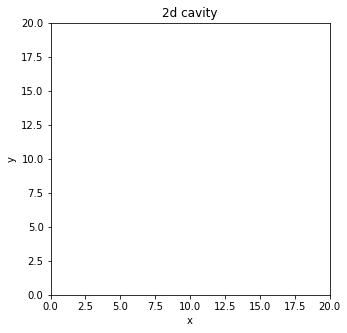

In [88]:
# 2d Bugers 方程式
images = []
# fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10,5))
# axe = axes[0]
# axe_2 = axes[1]
fig, axe = plt.subplots(1, 1, sharey=True, figsize=(5,5))

axe.set_xlabel("x")
axe.set_ylabel("y")
axe.set_xlim(0, 20)
axe.set_ylim(0, 20)
axe.set_title("2d cavity")
# axe_2.set_xlabel("x")
# axe_2.set_ylabel("y")
# axe_2.set_xlim(-1, 21)
# axe_2.set_ylim(0, 21)
rho_cip = rho_array.copy()
partial_rho_cip_x \
    = (np.concatenate([rho_cip[:, 1:], rho_x_upper_boundary[:, np.newaxis]], axis=1) \
       - np.concatenate([rho_x_lower_boundary[:, np.newaxis], rho_cip[:, :-1]], axis=1)) / 2 / Delta_x
partial_rho_cip_y \
    = (np.concatenate([rho_cip[1:, :], rho_y_upper_boundary[np.newaxis, :]], axis=0) \
       - np.concatenate([rho_y_lower_boundary[np.newaxis, :], rho_cip[:-1, :]], axis=0)) / 2 / Delta_y
rho_boundary = (rho_x_lower_boundary, rho_x_upper_boundary, rho_y_lower_boundary, rho_y_upper_boundary)

u_cip = u_array.copy()
partial_u_cip_x \
    = (np.concatenate([u_cip[:, 1:], u_x_upper_boundary[:, np.newaxis]], axis=1) \
       - np.concatenate([u_x_lower_boundary[:, np.newaxis], u_cip[:, :-1]], axis=1)) / 2 / Delta_x
partial_u_cip_y \
    = (np.concatenate([u_cip[1:, :], u_y_upper_boundary[np.newaxis, :]], axis=0) \
       - np.concatenate([u_y_lower_boundary[np.newaxis, :], u_cip[:-1, :]], axis=0)) / 2 / Delta_y
u_boundary = (u_x_lower_boundary, u_x_upper_boundary, u_y_lower_boundary, u_y_upper_boundary)

v_cip = v_array.copy()
partial_v_cip_x \
    = (np.concatenate([v_cip[:, 1:], v_x_upper_boundary[:, np.newaxis]], axis=1) \
       - np.concatenate([v_x_lower_boundary[:, np.newaxis], v_cip[:, :-1]], axis=1)) / 2 / Delta_x
partial_v_cip_y \
    = (np.concatenate([v_cip[1:, :], v_y_upper_boundary[np.newaxis, :]], axis=0) \
       - np.concatenate([v_y_lower_boundary[np.newaxis, :], v_cip[:-1, :]], axis=0)) / 2 / Delta_y
v_boundary = (v_x_lower_boundary, v_x_upper_boundary, v_y_lower_boundary, v_y_upper_boundary)
pressure_2d = pressure_array.copy()


# 安定条件の設定
cfl_condition = 1
diffusion_number_restriction = 1/2
# 時間発展させる
for n in range(50):
    delta_t = Delta_t
    cfl_max = np.max(np.abs(u_cip)) * delta_t / min(Delta_x, Delta_y)
    if cfl_max > cfl_condition:
        # CFL条件の判定
        # cfl_conditionより大きかったら、時間刻み幅dtを小さくしてCFL条件を満たすようにする
        delta_t = CFL * min(Delta_x, Delta_y) / np.max(np.abs(u_cip))
    diffusion_max = Mu * delta_t / (Delta_x**2 + Delta_y**2)
    if diffusion_max > diffusion_number_restriction:
        # 拡散数の判定
        # diffusion_number_restrictionより大きかったら、時間刻み幅dtを小さくして拡散数の条件を満たすようにする
        delta_t = diffusion_max * (Delta_x ** 2 + Delta_y**2) / Mu
        diffusion_number_x *= delta_t / Delta_t
        diffusion_number_y *= delta_t / Delta_t
    diffusion_numbers = (diffusion_number_x, diffusion_number_y)
    
    # rho
    rho_props = (rho_cip, partial_rho_cip_x, partial_rho_cip_y)
    rho_boundary = (rho_x_lower_boundary, rho_x_upper_boundary, rho_y_lower_boundary, rho_y_upper_boundary)
    rhox_boundary = (rhox_x_lower_boundary, rhox_x_upper_boundary, rhox_y_lower_boundary, rhox_y_upper_boundary)
    rhoy_boundary = (rhoy_x_lower_boundary, rhoy_x_upper_boundary, rhoy_y_lower_boundary, rhoy_y_upper_boundary)
    rho_coner = (rho_coner_xlow_ylow, rho_coner_xlow_yup, rho_coner_xup_ylow, rho_coner_xup_yup)
    # velocity x direction
    u_props = (u_cip, partial_u_cip_x, partial_u_cip_y)
    u_boundary = (u_x_lower_boundary, u_x_upper_boundary, u_y_lower_boundary, u_y_upper_boundary)
    ux_boundary = (ux_x_lower_boundary, ux_x_upper_boundary, ux_y_lower_boundary, ux_y_upper_boundary)
    uy_boundary = (uy_x_lower_boundary, uy_x_upper_boundary, uy_y_lower_boundary, uy_y_upper_boundary)
    u_coner = (u_coner_xlow_ylow, u_coner_xlow_yup, u_coner_xup_ylow, u_coner_xup_yup)
    # velocity y direction
    v_props = (v_cip, partial_v_cip_x, partial_v_cip_y)
    v_boundary = (v_x_lower_boundary, v_x_upper_boundary, v_y_lower_boundary, v_y_upper_boundary)
    vx_boundary = (vx_x_lower_boundary, vx_x_upper_boundary, vx_y_lower_boundary, vx_y_upper_boundary)
    vy_boundary = (vy_x_lower_boundary, vy_x_upper_boundary, vy_y_lower_boundary, vy_y_upper_boundary)
    v_coner = (v_coner_xlow_ylow, v_coner_xlow_yup, v_coner_xup_ylow, v_coner_xup_yup)
    
    # Advection phase
    rho_cip_star, partial_rho_cip_x_star, partial_rho_cip_y_star \
        = solve_advection_cip_2d(*rho_props, *rho_boundary, *rhox_boundary, *rhoy_boundary, *rho_coner, 
                                 dt=delta_t, velocity_x=u_cip, velocity_y=v_cip)
    u_cip_star, partial_u_cip_x_star, partial_u_cip_y_star \
        = solve_advection_cip_2d(*u_props, *u_boundary, *ux_boundary, *uy_boundary, *u_coner, 
                                 dt=delta_t, velocity_x=u_cip, velocity_y=v_cip)
    v_cip_star, partial_v_cip_x_star, partial_v_cip_y_star \
        = solve_advection_cip_2d(*v_props, *v_boundary, *vx_boundary, *vy_boundary, *v_coner, 
                                 dt=delta_t, velocity_x=u_cip, velocity_y=v_cip)
    velocities = (u_cip_star, v_cip_star)
    velocity_x_boundaries = (u_x_lower_boundary, u_x_upper_boundary, u_y_lower_boundary, u_y_upper_boundary)
    velocity_y_boundaries = (v_x_lower_boundary, v_x_upper_boundary, v_y_lower_boundary, v_y_upper_boundary) 
    
    # Diffusion phase
    u_diffusion = solve_diffusion_2d(u_cip_star, *u_boundary, *diffusion_numbers)
    partial_u_diffusion_x = solve_diffusion_2d(partial_u_cip_x_star, *ux_boundary, *diffusion_numbers,
                                         *velocities, *velocity_x_boundaries,
                                         update_partial=1, u_array_integral=u_cip_star)
    partial_u_diffusion_y = solve_diffusion_2d(partial_u_cip_y_star, *uy_boundary, *diffusion_numbers,
                                         *velocities, *velocity_y_boundaries,
                                         update_partial=2, u_array_integral=u_cip_star)
    v_diffusion = solve_diffusion_2d(v_cip_star, *v_boundary, *diffusion_numbers)
    partial_v_diffusion_x = solve_diffusion_2d(partial_v_cip_x_star, *vx_boundary, *diffusion_numbers,
                                         *velocities, *velocity_x_boundaries,
                                         update_partial=1, u_array_integral=v_cip_star)
    partial_v_diffusion_y = solve_diffusion_2d(partial_v_cip_y_star, *vy_boundary, *diffusion_numbers,
                                         *velocities, *velocity_y_boundaries,
                                         update_partial=2, u_array_integral=v_cip_star)
    # Boundary condition
    u_x_lower_boundary, u_x_upper_boundary, u_y_lower_boundary, u_y_upper_boundary = update_boundary_condition(u_diffusion, *u_boundary, 1)
    v_x_lower_boundary, v_x_upper_boundary, v_y_lower_boundary, v_y_upper_boundary = update_boundary_condition(v_diffusion, *v_boundary, 2)
    
    # For checking bugs of pressure equation
    # rho_cip_star = rho_cip
    # u_diffusion = u_cip
    # v_diffusion = v_cip
    
    # Pressure equation
    poisson = pressure_equation(pressure_2d, 
                                pressure_x_lower_boundary, pressure_x_upper_boundary, 
                                pressure_y_lower_boundary, pressure_y_upper_boundary,
                                rho_cip_star, u_diffusion, v_diffusion,
                                u_x_lower_boundary, u_x_upper_boundary,
                                v_y_lower_boundary, v_y_upper_boundary, 
                                np.sqrt(Gamma * pressure_2d / rho_cip_star), delta_t, 9.8)
    pressure_2d = poisson.solve_poisson_2d()
    u_cip, v_cip = poisson.update_velocity()
    partial_u_cip_x = partial_u_diffusion_x
    partial_u_cip_y = partial_u_diffusion_y
    partial_v_cip_x = partial_v_diffusion_x
    partial_v_cip_y = partial_v_diffusion_y
    rho_cip = rho_cip_star
    partial_rho_cip_x = partial_rho_cip_x_star
    partial_rho_cip_y = partial_rho_cip_y_star
    
    # Boundary condition
    u_x_lower_boundary, u_x_upper_boundary, u_y_lower_boundary, u_y_upper_boundary = update_boundary_condition(u_diffusion, *u_boundary, 1)
    v_x_lower_boundary, v_x_upper_boundary, v_y_lower_boundary, v_y_upper_boundary = update_boundary_condition(v_diffusion, *v_boundary, 2)
    
    # For creating graphs
    img_2 = axe.contourf(x_array, y_array, pressure_2d, levels=10, cmap="Blues", alpha=0.8).collections
    img = axe.quiver(x_array, y_array, u_cip, v_cip, color='red', angles='uv')
    images.extend([img_2 + [img]])
ani = ArtistAnimation(fig, images, interval=50)
ani.save('2d-cavity.gif', writer="pillow")
HTML(ani.to_html5_video())


## 参考文献
* [圧縮性流体力学 Compressible Fluid Dynamics](https://www3.chubu.ac.jp/documents/faculty/nakamura_yoshiaki/content/626/626_59b7fd02e2c6d1589bfbbacd56af6678.pdf)
* [ナビエ・ストークス方程式を導出する](http://shimaphoto03.com/science/ns-equation/)
* [もっと知りたい！ 熱流体解析の基礎64　第6章 熱流体解析の手法：6.5.4 SIMPLE法](https://www.cradle.co.jp/media/column/a249)
* 清水文雄, 田中和博, 畠中清史, 重藤博司, 清水 剛, [CCUP 法を用いた水槽内における気液界面の数値解析](http://www2.nagare.or.jp/jscfd/cfds15/papers/E07/E07-4.pdf), 第 15回数値流体力学シンポジウム.
* 姫野武洋, 渡辺紀徳, [低重力環境における熱流体管理に関する研究 : 第1報,熱流動解析に適したCCUP法-TCUP法-の提案](https://doi.org/10.1299/kikaib.69.266), 日本機械学会B編 69 巻 678 号 p. 266-273, 2003.
* 姫野武洋, 根岸秀世, 野中聡, 井上智博, 渡辺紀徳, 鵜沢聖治, [様々な加速度環境における自由表面流の数値解析 : CIP法,MARS法,Level Set法を協調した解法の改良](https://doi.org/10.1299/kikaib.76.765_778), 日本機械学会B編 76 巻 765 号 p. 778-788, 2010.
* Yabe, T., Wang, P. Y., Unified Numerical Procedure for Compressible and Incompressible Fluid, J. Phys. Soc. Japan, 60-7 (1991), pp. 2105-2108.